# Simplified model for UHECR data

Here we use a simplified version of the model described in *Soiaporn, K. et al., 2012. Multilevel Bayesian framework for modeling the production, propagation and detection of ultra-high energy cosmic rays. arXiv.org, astro-ph.HE(3), pp.1249–1285* and summarised in soiaporn_model.ipynb to generate simulated data for the UHECR arrival directions.


A generative model is built here to simulate datasets and test the fit for known parameters. 

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
from matplotlib import pyplot as plt
import numpy as np
from fancy import *

In [2]:
# read in relevant data
source_file = 'data/agn_catalog.dat'

# define a Data() instance to handle all data
data = Data()

# add the AGN data
data.add_source(source_file, 'AGN')

## Detection effects

The arrival direction of UHECR is reconstructed with a certain uncertainty by the PAO team. This is quantified here by the von Mises-Fisher distribution for the data:

<div><center>
$P(d_i | \omega_i) = \frac{\kappa}{4\pi sinh(\kappa)}e^{\kappa d_i \omega_i}$    
<center></div>

We can sample from this distibrution, assuming the true arrival direction is a certain source.

In [3]:
# testing
skycoords = data.source['AGN'].coord
omega = [skycoords.cartesian.x, skycoords.cartesian.y, skycoords.cartesian.z] 
mu = np.transpose(omega)[1]
print (mu)
print(np.transpose(data.source['AGN'].distance))

from astropy.coordinates import *
#Galactic().representation_info

[ -1.65682473  -1.91113329 -14.78521225]
[14.5 15.  12.3 13.7 11.5 12.5  6.6 10.  10.  13.1  3.9 13.8  4.   8.6
  8.3 13.9 13.1]


In [7]:
from vMF import *
from astropy.coordinates import SkyCoord
from astropy import units as u

# get the positions of the sources
skycoords = data.source['AGN'].coord

# convert to cartesian coordinates
omega = [skycoords.cartesian.x, skycoords.cartesian.y, skycoords.cartesian.z] 

# define the concentration parameter
kappa = 100

# sample from the first source
num_samples = 1000
mu = np.transpose(omega)[0]

# normalise to unit sphere
norm = np.linalg.norm(mu)
mu = mu / norm
print ('true direction:',mu)

# sample
detected_coords = sample_vMF(mu, kappa, num_samples)
print ('sampled direction:', detected_coords[0])

# get x, y, z in Mpc
x = np.transpose(detected_coords)[0] * norm
y = np.transpose(detected_coords)[1] * norm
z = np.transpose(detected_coords)[2] * norm

true direction: [ 0.00766903 -0.87878365 -0.47715876]
sampled direction: [-0.04963023 -0.91553988 -0.39915357]


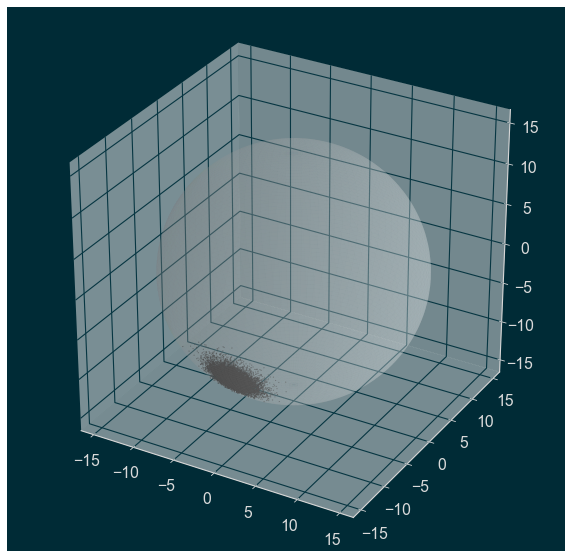

In [8]:
from mpl_toolkits.mplot3d import Axes3D
# have a look on a sphere to check

def make_unit_sphere():
    r = norm
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0 * pi:100j]
    x = r * sin(phi) * cos(theta)
    y = r * sin(phi) * sin(theta)
    z = r * cos(phi)
    return x, y, z

x_circ, y_circ, z_circ = make_unit_sphere()

# plot generated points on a unit * norm sphere
fig = plt.figure(figsize = [10, 10])
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(x_circ, y_circ, z_circ,  
                rstride = 1, cstride = 1, 
                color = 'white', alpha = 0.2, linewidth = 0)
ax.scatter(x,y,z, color = 'k', s = 1, alpha = 0.5)

/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


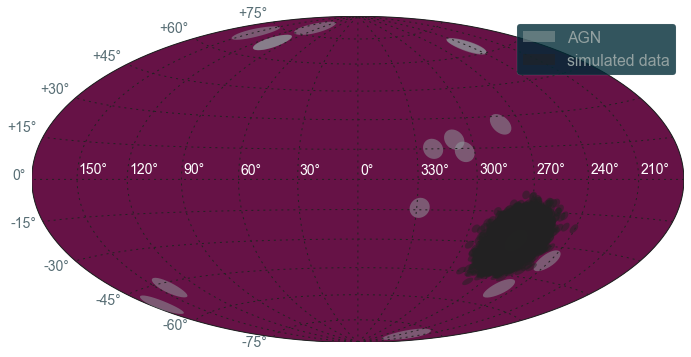

In [10]:
# convert back to galactic coordinates
d = SkyCoord(x, y, z, unit = 'mpc', representation_type = 'cartesian', frame = 'galactic')
d.representation_type = 'spherical'

lons = d.galactic.l.wrap_at(360 * u.deg).deg
lats = d.galactic.b.wrap_at(180 * u.deg).deg

# plot the results on a skymap
fig, skymap = data.show()
label = True
for lon, lat in np.nditer([lons, lats]):
    if label:
        skymap.tissot(lon, lat, 2, npts = int(100), facecolor = 'k', alpha = 0.5, 
                      label = 'simulated data')
        label = False
    else:
        skymap.tissot(lon, lat, 2, npts = int(100), facecolor = 'k', alpha = 0.5)

plt.gca()
plt.legend()

## Sources

For the most basic model start with just the sources. The source distribution is defined by the luminosity function $(F_T, f)$ and the hyperparameters $s$, $a$ and $b$:

<div><center>
$ g(F_T) = \frac{1}{s}e^{-F_T/s}$
<center></div>
<div><center>
$ h(f) = \frac{1}{B(a,b)}f^{a-1}(1-f)^{b-1}$
<center></div>

With s = $0.01 \times 4\pi$, and a = b = 1.
We have the *luminosity function* of a standard candle: $F_k = I/D_k^2$, but we choose instead to represent I through the total source flux: $ F_A = \sum_{k=1}^{N_A} $. So, $F_k = w_kF_A$ with the weights $w_k = \frac{1/D_k^2}{\sum_{j=1}^{N_A} 1/D_j^2}$. 

In [ ]:
# use this model to generate simulated data from the given AGN sources
# distances to AGN
D = data.source['AGN'].distance
# number of AGN
N_A = len(D) 

# The total flux
F_T 

# function to calculate the weights
def get_weights(D):
    normalisation = 0
    for D_j in D:
        normalisation += (1 / D_j**2)  
    
    w = []
    for D_k in D:
        w.append( (1 / D_k**2) / normalisation)
    w = np.asarray(w)
    return w

w = get_weights(D)
